### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


### Plot Series Function

This function plots a time series with various customization options.

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    # Plot the series with the given time indices
    plt.plot(time[start:end], series[start:end], format, label=label)
    
    plt.xlabel("Time")
    
    plt.ylabel("Value")
    
    if label:
        plt.legend(fontsize=14)
    
    # Add a grid to the plot for better readability
    plt.grid(True)


### Stock Data Preparation

This section of code reads stock data from a CSV file, converts date columns, and splits the data into training, testing, and validation sets.

In [3]:
stock_name = pd.read_csv('stockdatas/HDFCBANK.NS.csv')

# Convert series into datetime type
stock_name['Date'] = pd.to_datetime(stock_name['Date'])

# Save target series
series = stock_name['Close']

# Creating train data set
train_split_date = '2024-05-27'
train_split_index = np.where(stock_name.Date == train_split_date)[0][0]
x_train = stock_name.loc[stock_name['Date'] <= train_split_date]['Close']

# Creating test data set
test_split_date = '2024-07-29'
test_split_index = np.where(stock_name.Date == test_split_date)[0][0]
x_test = stock_name.loc[stock_name['Date'] >= test_split_date]['Close']

# Creating valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = stock_name.loc[(stock_name['Date'] < test_split_date) & (stock_name['Date'] > train_split_date)]['Close']

### Data Visualization: Train, Validation, and Test Split

This section of code sets up the style for charts using Seaborn, creates a plot to visualize the splits of training, validation, and testing datasets, and prints the index values for verification.

1134 1135 1176 1177 1238


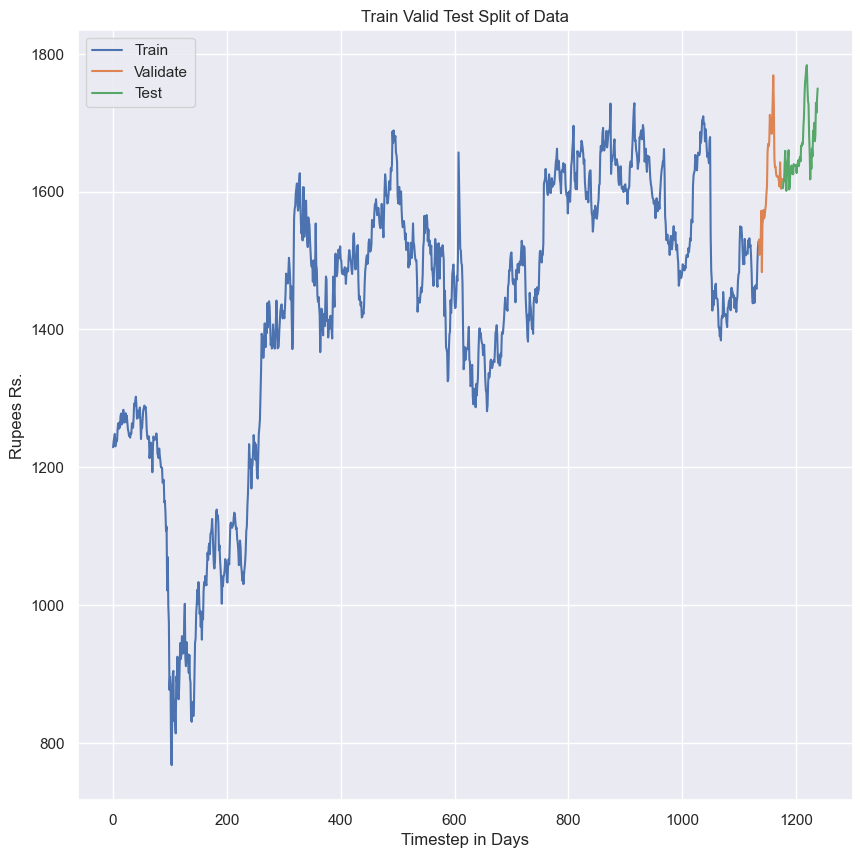

In [4]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Rupees Rs.')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())


### Make dictionary for error metrics

In [5]:
model_mae_scores = {}
model_rmse_scores = {}
model_mape_scores = {}

### Moving Average Calculation and Visualization

This section of code calculates a 20-day moving average of the stock's closing prices and visualizes it alongside the actual test data.

Text(0.5, 1.0, 'SMA20 vs Actual')

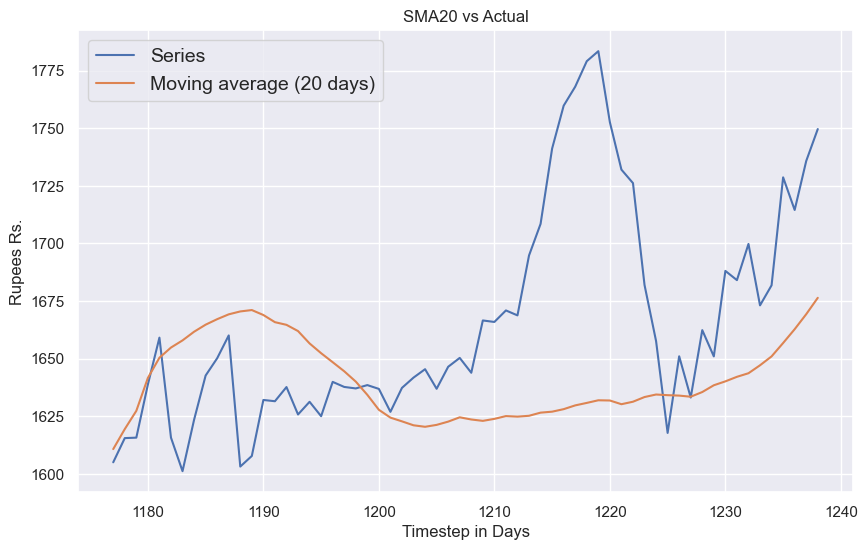

In [6]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = stock_name['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:stock_name.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Rupees Rs.')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

### Model Evaluation for Simple Moving Average (SMA 20)

This section of code calculates and stores the evaluation metrics for the Simple Moving Average (SMA) model based on the test data.

In [7]:
model_mae_scores['SMA 20'] = mean_absolute_error(x_test, moving_avg_forecast)
model_rmse_scores['SMA 20'] = root_mean_squared_error(x_test, moving_avg_forecast)
model_mape_scores['SMA 20'] = mean_absolute_percentage_error(x_test, moving_avg_forecast)
print("mae -", model_mae_scores['SMA 20'])
print("rmse -", model_rmse_scores['SMA 20'])

print("mape-",model_mape_scores['SMA 20'])

mae - 42.774032100554436
rmse - 57.31345555888105
mape- 0.025181444464031155


### Moving Average Calculation and Visualization (5-Day SMA)

This section of code calculates a 5-day moving average of the stock's closing prices and visualizes it alongside the actual test data.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

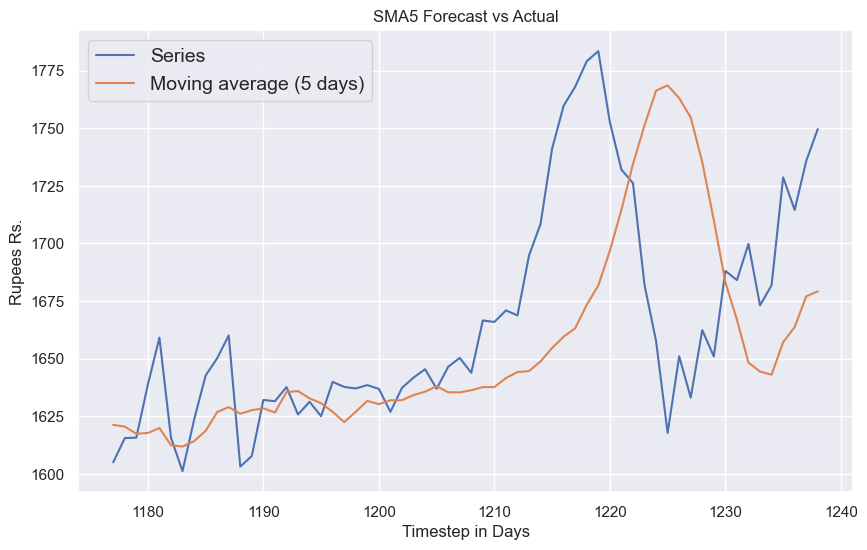

In [8]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = stock_name['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:stock_name.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Rupees Rs.')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

### Model Evaluation for Simple Moving Average (SMA 5)

This section of code calculates and stores the evaluation metrics for the 5-day Simple Moving Average (SMA) model based on the test data.


In [9]:
# Calculate MAE
model_mae_scores['SMA5'] = mean_absolute_error(x_test, moving_avg_forecast)
model_rmse_scores['SMA5'] = root_mean_squared_error(x_test, moving_avg_forecast)

model_mape_scores['SMA5'] = mean_absolute_percentage_error(x_test, moving_avg_forecast)
print("mae -", model_mae_scores['SMA5'])
print("rmse -", model_rmse_scores['SMA5'])

print("mape-",model_mape_scores['SMA5'])


mae - 36.42322052986393
rmse - 51.8139644237547
mape- 0.02156308075609828


### Fitting an ARIMA Model to the Training Data

This section of code imports the necessary library and fits an ARIMA model to the training dataset.

In [10]:
import statsmodels.api as sm


stock_name_arima = sm.tsa.arima.ARIMA(x_train, order=(4,2,0))
stock_name_arima_fit = stock_name_arima.fit()
print(stock_name_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1135
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -5217.536
Date:                Tue, 05 Nov 2024   AIC                          10445.071
Time:                        15:17:53   BIC                          10470.234
Sample:                             0   HQIC                         10454.577
                               - 1135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7674      0.021    -37.285      0.000      -0.808      -0.727
ar.L2         -0.6237      0.028    -22.589      0.000      -0.678      -0.570
ar.L3         -0.4427      0.030    -14.747      0.0

### Iterative Forecasting with ARIMA Model

This section of code implements an iterative forecasting approach using the ARIMA model, where predictions are made one step ahead based on the previous observations.

In [11]:
#  list of x train valuess
history = [x for x in x_train]

# e list for predictions
model_predictions = []

N_test_observations = len(x_test)

for time_point in list(x_test.index[:]):
    model = sm.tsa.arima.ARIMA(history, order=(4,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_percentage_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 0.010246636488484399
Stored 'model_predictions' (list)


### Performance Evaluation of the ARIMA Model

This section of code calculates the evaluation metrics for the ARIMA model's predictions and prints the results.

In [12]:
model_predictions = np.array(model_predictions).flatten()

model_mae_scores['Arima'] = mean_absolute_error(x_test, model_predictions)
model_rmse_scores['Arima'] = root_mean_squared_error(x_test, model_predictions)

model_mape_scores['Arima'] = mean_absolute_percentage_error(x_test, model_predictions)
print("mae -", model_mae_scores['Arima'])
print("rmse -", model_rmse_scores['Arima'])

print("mape-",model_mape_scores['Arima'])


mae - 17.021584910597124
rmse - 24.423193856579804
mape- 0.010246636488484399


### Visualization of ARIMA Model Predictions

This section of code plots the predicted prices generated by the ARIMA model against the actual prices from the test dataset, providing a visual comparison.

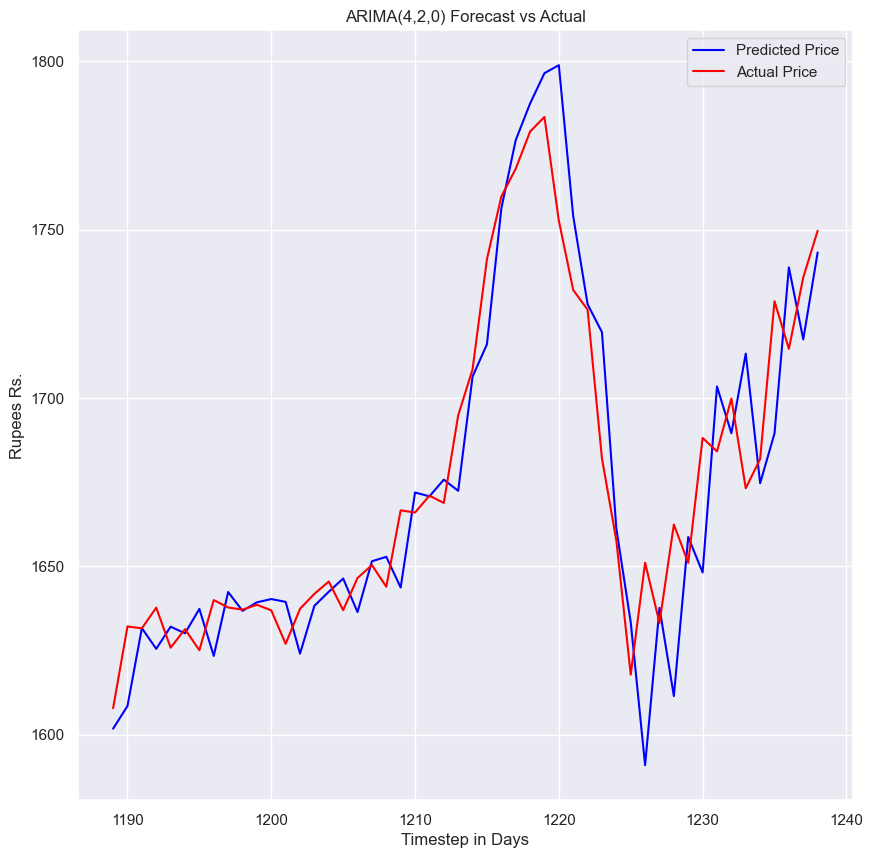

<Figure size 1000x600 with 0 Axes>

In [13]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-50:], model_predictions[-50:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-50:], x_test[-50:], color='red', label='Actual Price')
plt.ylabel('Rupees Rs.')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

### Creating a DataFrame for Model Evaluation Metrics

This section of code constructs a Pandas DataFrame to organize and display the evaluation metrics (MAE, RMSE, and MAPE) for different forecasting models.

In [14]:
df = pd.DataFrame({'Mae_score': pd.Series(model_mae_scores),
                   'Rmse_score': pd.Series(model_rmse_scores),
                   'Mape_percentage': pd.Series(model_mape_scores)})


In [15]:
# Converting MAPE to Percentage Format

df['Mape_percentage'] = df['Mape_percentage'].multiply(100)

In [16]:
# Resetting the DataFrame Index

df2=df.reset_index()

#Using reset_index, inplace=True
df.reset_index(inplace=True)
df

,index,Mae_score,Rmse_score,Mape_percentage
0,SMA 20,42.774032,57.313456,2.518144
1,SMA5,36.423221,51.813964,2.156308
2,Arima,17.021585,24.423194,1.024664


In [17]:
# This section of code uses the `melt` function from Pandas to transform the DataFrame from a wide format to a long format.

df = pd.melt(df, id_vars="index", var_name="metric", value_name="value")
df

,index,metric,value
0,SMA 20,Mae_score,42.774032
1,SMA5,Mae_score,36.423221
2,Arima,Mae_score,17.021585
3,SMA 20,Rmse_score,57.313456
4,SMA5,Rmse_score,51.813964
5,Arima,Rmse_score,24.423194
6,SMA 20,Mape_percentage,2.518144
7,SMA5,Mape_percentage,2.156308
8,Arima,Mape_percentage,1.024664


In [18]:
# Setting Figure Resolution in Matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Result

### Visualizing Model Errors with a Bar Plot

This section of code generates a bar plot using Seaborn to visualize the errors of various forecasting models tested in the analysis.

Text(0.5, 1.0, ' Errors of All Models Tested')

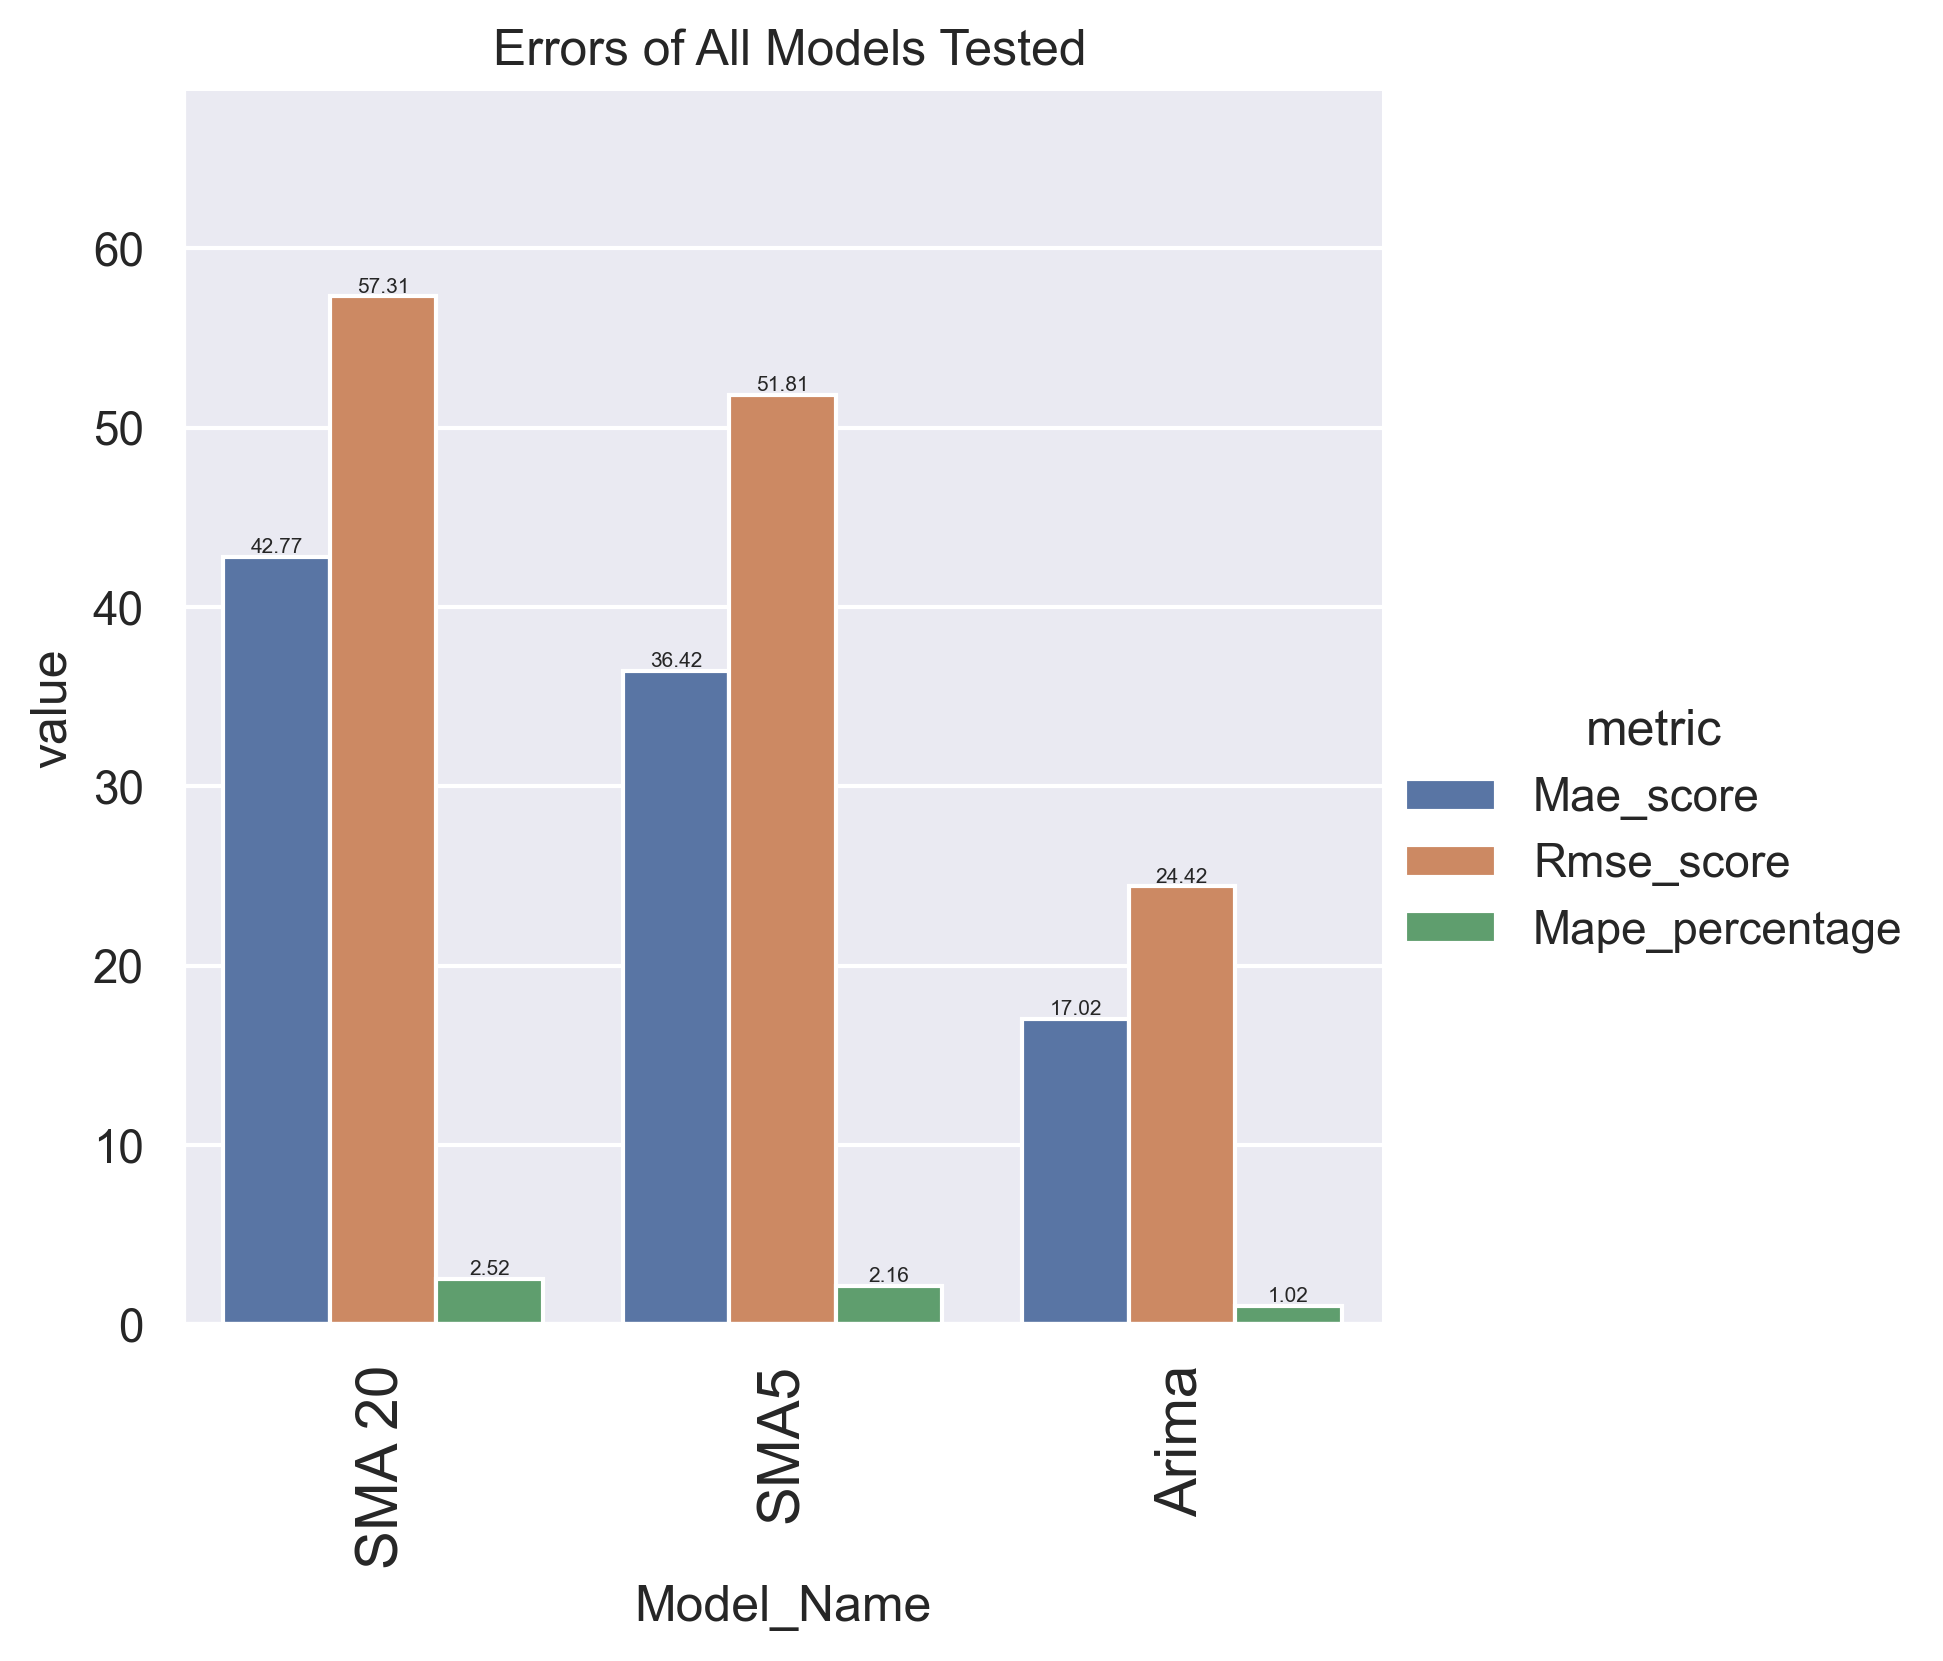

In [19]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [20,100]
g =sns.catplot(x='index', y='value', hue='metric', data=df, kind='bar' , legend = True)

ax = g.facet_axis(0,0)
for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge',fontsize=5)
ax.margins(y=0.2)
plt.xticks(rotation='vertical',fontsize=14)
plt.xlabel('Model_Name')
plt.title(' Errors of All Models Tested')